# Importing Required Machine Learning Libraries and Helper Functions

In [ ]:
import os                        # OS stands for Operating System and provides ways for python to interact with files or directories
from collections import Counter  # Collections is a package for handling data
from pprint import pprint

import pandas as pd              # Pandas is a data analysis library which we'll primarily use to handle our dataset
import numpy as np               # Numpy is a package for scientific computing. We'll use it for some of it's math functions
#import pymatgen                  # Pymatgen is a library for materials analysis which we use to interpret our material compositions

In [ ]:
import matplotlib                # Matplotlib is the plotting package that we'll use throughout the lab
import matplotlib.pyplot as plt
import seaborn as sns            # Seaborn is a Python data visualization library based on matplotlib

In [ ]:
import sklearn                   # Scikit-learn is a machine learning package, providing the backbone for the work we'll perform
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate,GridSearchCV,ParameterGrid
from sklearn.model_selection import KFold,RepeatedKFold

In [ ]:
import graphviz                  # graphviz is a package that helps visualize decision trees

In [ ]:
seed = 2345312
#There are a number of steps we'll take which would normally have a random state. In order to have consistent results we'll fix them all by setting a random seed for all those processes.

# Data Pre-Processing

In [ ]:
df = pd.read_csv('/content/bandgap_data_v2.csv')
df.head()

,index,chemicalFormula Clean,Band gap values Clean,Band gap units,Band gap method,Reliability
0,0,Li1F1,13.60,eV,Reflection,1
1,1,Li1F1,12.61,eV,Reflection,1
2,2,Li1F1,12.60,eV,Estimated,2
3,3,Li1F1,12.10,eV,Absorption,2
4,4,Li1F1,12.00,eV,Absorption,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  1447 non-null   int64  
 1   chemicalFormula Clean  1447 non-null   object 
 2   Band gap values Clean  1447 non-null   float64
 3   Band gap units         1447 non-null   object 
 4   Band gap method        1263 non-null   object 
 5   Reliability            1447 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 68.0+ KB


In [ ]:
# Filter for only Reliability 1
df_filtered = df[df["Reliability"]==1]
# Print filtered data
df_filtered

,index,chemicalFormula Clean,Band gap values Clean,Band gap units,Band gap method,Reliability
0,0,Li1F1,13.600,eV,Reflection,1
1,1,Li1F1,12.610,eV,Reflection,1
6,6,Li1Cl1,9.330,eV,Reflection,1
7,7,Li1Br1,7.950,eV,Absorption,1
9,9,Li3Sb1,1.000,eV,Thermal activation,1
...,...,...,...,...,...,...
1433,1445,Bi,0.015,eV,Magnetoreflection,1
1436,1448,Th1O2,5.750,eV,NaN,1
1437,1449,Th1O2,3.500,eV,Absorption,1
1443,1455,UO,1.500,eV,Thermal activation,1


In [ ]:
#Looking through the filtered data and paying attention to the chemical formula column,
#there are still some formulas for which we have multiple measurements.
#Because we don't have another way to decide which data points to keep,
#let's average the values between these multiple measurements.

df_clean=df_filtered.groupby("chemicalFormula Clean",as_index=False).mean()
df_clean.head()

<ipython-input-34-d738d9b3e691>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_clean=df_filtered.groupby("chemicalFormula Clean",as_index=False).mean()


,chemicalFormula Clean,index,Band gap values Clean,Reliability
0,Ag1Br1,808.5,3.485,1.0
1,Ag1Cl1,793.5,4.190,1.0
2,Ag1N3,783.0,3.900,1.0
3,Ag1Te1,820.0,0.850,1.0
4,Ag2O1,785.0,1.200,1.0


In [ ]:
df_clean["Band gap values Clean"].describe().round(3)
# Trying to get information about what we have to predict

count    467.000
mean       2.231
std        2.287
min        0.009
25%        0.695
50%        1.435
75%        3.000
max       13.105
Name: Band gap values Clean, dtype: float64

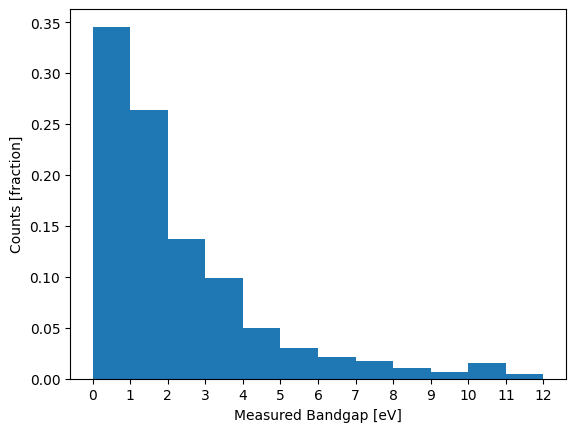

In [ ]:
# we'll also define a simple histogram plotting function to use later
def histogram_plot(data):
    fig1,ax1 = plt.subplots()
    ax1.hist(data,bins=range(13),density=1)
    ax1.set_xticks(range(13))
    ax1.set_xlabel('Measured Bandgap [eV]')
    ax1.set_ylabel('Counts [fraction]')
    plt.show()

histogram_plot(df_clean["Band gap values Clean"].astype("float"))

# Feature Generation

In [ ]:
#This section covers generating features from chemical formulas in the dataset.
# This featurization step is necessary to turn the text representation of materials into a
# numerical representation that the models can understand!

In [ ]:
cwd = os.getcwd()
generated_features_path = os.path.join(cwd,"./generated_features/generated_features.csv")
features_df = pd.read_csv(generated_features_path)

In [ ]:
#split features_df into two dataframes
target_data_df = pd.DataFrame([df["chemicalFormula Clean"],df["Band gap values Clean"],df["Band gap units"],df["index"],df["Reliability"]])
features_df = df.drop(columns=['index','Reliability','Band gap values Clean','Band gap units','chemicalFormula Clean'])

In [ ]:
target_data_df.head()

In [ ]:
features_df.head()

# Feature Engineering

In [ ]:
# The next big step we need to do before building models and making prediction
# is to make sure our features are useful for modeling.
# We'll perform three checks on our features that should improve their usefulness.
#This step is similar to the initial dataset cleaning / pre-processing that we did at the start,
# except now we're focusing on "cleaning" our features instead of cleaning the output data and compositions.

# Feature Engineering Steps:
# 1) Remove Constant Columns
# 2) Remove Highly Correlated Columns
# 3) Normalize Features

In [ ]:
# Remove Constant Columns
features_df_noconstant = features_df.loc[:, (features_df != features_df.iloc[0]).any()]

# report number of columns
len(features_df_noconstant.columns)

1

In [ ]:
#Remove Highly correlated Features
features_corr_df = features_df_noconstant.corr(method="pearson").abs()
features_corr_df.iloc[:5, :5] # Preview the first 5 rows/columns of the correlation matrix

<ipython-input-44-4c15ca392e83>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  features_corr_df = features_df_noconstant.corr(method="pearson").abs()


""


In [ ]:
# before removing correlated features
fig1, ax1 = plt.subplots(figsize=(10,5))
c = ax1.pcolor(features_corr_df,cmap="Blues")
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Feature Numbers')
ax1.set_ylabel('Feature Numbers')
ax1.set_aspect('equal')
plt.colorbar(c,ax=ax1)
plt.show()

In [ ]:
# Filter the features with correlation coefficients above 0.95
upper = features_corr_df.where(np.triu(np.ones(features_corr_df.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
features_df_lowcorr = features_df_noconstant.drop(columns=to_drop)
# recalculate the correlation matrix so we can compare
features_corr_df_update = features_df_lowcorr.corr(method="pearson").abs()

<ipython-input-46-74f19492ac12>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = features_corr_df.where(np.triu(np.ones(features_corr_df.shape), k=1).astype(np.bool))
<ipython-input-46-74f19492ac12>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  features_corr_df_update = features_df_lowcorr.corr(method="pearson").abs()


In [ ]:
# plot correlation after removing highly correlated features

fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
c1 = ax1.pcolor(features_corr_df,cmap="Blues")
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Feature Numbers')
ax1.set_ylabel('Feature Numbers')
ax1.set_aspect('equal')

plt.colorbar(c1,ax=ax1)

c2 = ax2.pcolor(features_corr_df_update,cmap="Blues")
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Feature Numbers')
ax2.set_ylabel('Feature Numbers')
ax2.set_aspect('equal')
plt.colorbar(c2,ax=ax2)
plt.show()

In [ ]:
len(features_df_lowcorr.columns)

1

In [ ]:
minmax_features = MinMaxScaler().fit_transform(features_df_lowcorr)
minmax_features_df = pd.DataFrame(minmax_features,columns=features_df_lowcorr.columns)
minmax_features_df.iloc[:5, :5]

# Setup for Model Evaluation


In [ ]:
# Establishing Train Test Split
X_train = minmax_features_df                      # inputs/features
y_train = target_data_df["Band gap values Clean"] # outputs/targets

In [ ]:
X_test=df
y_test=df

In [ ]:
# Evaluating and Plotting Train Test Split
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,5), sharex = True, gridspec_kw={'hspace': 0})
fig.set_tight_layout(False)
myarray = df["Band gap values Clean"]

bins = np.true_divide(range(28),2)

l1 = sns.distplot(y_train.astype("float"), hist = True, norm_hist = True, kde = False, bins = bins, hist_kws={"edgecolor": "white"}, label = 'training set', ax = ax1)
l2 = sns.distplot(y_test.astype("float"), hist = True, norm_hist = True, kde = False, bins = bins, hist_kws={"edgecolor": "white", "color": "orange"}, label = 'test set', ax = ax2)
l3 = sns.distplot(myarray, hist = True, norm_hist = True, kde = False, bins = bins, hist_kws={"histtype": "step","linewidth": 3, "alpha": 1, "color": "grey"}, ax = ax1)
l4 = sns.distplot(myarray, hist = True, norm_hist = True, kde = False, bins = bins, hist_kws={"histtype": "step","linewidth": 3, "alpha": 1, "color": "grey"}, label = 'full dataset', ax = ax2)


ax1.set_xticks(range(14))
ax2.set_xticks(range(14))
ax2.xaxis.label.set_visible(False)
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
fig.suptitle('Comparing histograms of the train/test split')
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.legend(handles, labels, loc = 'center left', bbox_to_anchor=(1, 0.5),prop={'size': 16})
plt.xlabel('Measured Bandgap (eV)')
_ = plt.ylabel('Density')

# Fitting and Evaluating a Default Model

In [ ]:
# Fitting a Decision Tree Model
Default_model = RandomForestRegressor(random_state=seed,n_estimators=1,bootstrap=False).fit(X_train,y_train) # fit the decision tree model
print('Model training complete.')
# print('Tree depth:', [estimator.tree_.max_depth for estimator in Default_model.estimators_])
# for importance in zip (estimator.feature_importances_ for estimator in Default_model.estimators_):
#     print (importance)
#print('Leaf nodes:',[estimator.tree_.n_leaves for estimator in Default_model.estimators_])\


In [ ]:
# Evaluating our model
Train_predictions = Default_model.predict(X_train)    # Make predictions on training data
Test_predictions = Default_model.predict(X_test)      # Make predictions on testing data

parity_plot(y_train,Train_predictions,y_test,Test_predictions,title_left="Training Data Parity Plot",title_right="Test Data Parity Plot") # build both plots
parity_plot(y_train,Train_predictions,y_test,Test_predictions,"Training Data","Test Data")  # print error metrics for training data

# Improving the Model by Optimizing Hyperparameters

In [ ]:
# set up hyperparameter grid (a dictionary of hyperparameter candidates that we want the optimization strategy to consider)

number_of_trees = [1,10,25,50]
opt_dict = {'n_estimators':number_of_trees,'bootstrap':['True']}

In [ ]:
#Setting up a cross-validation scheme
# kfold = KFold(n_splits=5,random_state=seed,shuffle=True)
kfold = RepeatedKFold(n_splits=5,random_state=seed,n_repeats=5)

In [ ]:
# VISUALIZING LEARNING CURVES
# plot number of trees vs train and test MSE

opt_dict_array = opt_dict["n_estimators"]                     # array of grid points (x-axis)
train_mse = CV.cv_results_["mean_train_neg_mean_squared_error"] # MSE of training set at each grid point (y-axis)
test_mse = CV.cv_results_["mean_test_neg_mean_squared_error"]   # MSE of test set at each grid point (y-axis)

fig1,ax1 = plt.subplots(figsize=(8,4))
ax1.scatter(opt_dict_array, -train_mse)
ax1.scatter(opt_dict_array, -test_mse)
# ax1.fill_between(opt_dict_array, -train_mse, -test_mse, alpha=0.1)
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Compare training and validation MSE vs hyperparameter')
plt.legend(["Training","Validation","difference"])
plt.show()
print("Minimum Mean Squared Error: ", round(min(-test_mse),4))
print("Number of Trees at minimum: ", opt_dict_array[np.argmin(-test_mse)])

# Evaluating Our Model

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.tree import *
from sklearn.metrics import f1_score

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f = f1_score(y_true = y_test , y_pred = y_pred,average = 'weighted')
print(f)